In [12]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import clmm
import numpy as np
import descwl_shear_sims as dss
import matplotlib.pyplot as plt

In [13]:
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)
halo = clmm.Modeling(massdef="mean", delta_mdef=200, halo_profile_model="nfw")
halo.set_cosmo(cosmo)
halo.set_concentration(4)
halo.set_mass(1.0e15)
z_cl = 1.0
# source properties
z_source = 2.0  # all sources in the same plane

shear_obj = dss.shear.ShearNFW(halo, z_cl)

# step1: make sure the direction is correct

In [23]:
# generate positions
n_gal = 20
theta = np.linspace(0, 360, n_gal) / n_gal
x = np.cos(theta) * 5
y = np.sin(theta) * 5
shifts = np.zeros(n_gal, dtype=[('dx', 'f8'), ('dy', 'f8')])
shifts['dx'] = x
shifts['dy'] = y

# get the shear
g1, g2 = shear_obj.get_shear(z_source, shifts)
gamma = g1 + 1j * g2

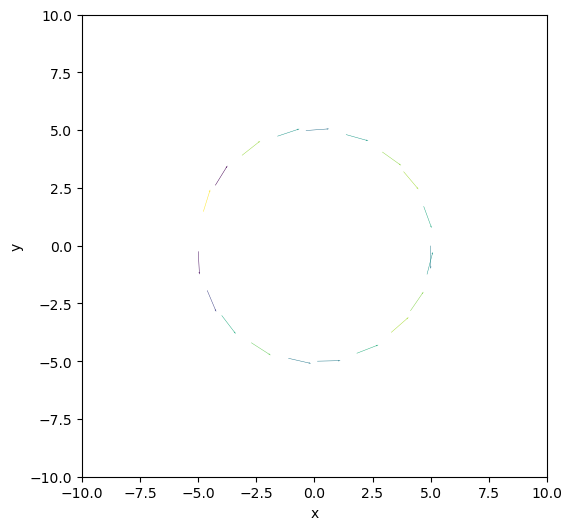

In [22]:
angles = np.angle(gamma, deg=True) / 2.
lengths = np.abs(gamma)

# Create whisker plot
plt.figure(figsize=(6, 6))
plt.quiver(x, y, np.cos(np.deg2rad(angles)), np.sin(np.deg2rad(angles)), lengths,
           angles='xy', scale_units='xy', scale=1, width=0.001)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# step2: make sure the amplitude is correct

In [28]:
n_gal = 1
d_array = []
g_array = []
for i in range(10):
    shifts = np.zeros(n_gal, dtype=[('dx', 'f8'), ('dy', 'f8')])
    shifts['dx'][0] = 3.0 ** i 
    shifts['dy'][0] = 0.
    print(shifts)
    # get the shear
    g1, g2 = shear_obj.get_shear(z_source, shifts)
    gabs = np.abs(g1 + 1j * g2)
    d_array.append(3 ** i)
    g_array.append(gabs)
d_array = np.array(d_array)
g_array = np.array(g_array)

[(1., 0.)]
[(3., 0.)]
[(9., 0.)]
[(27., 0.)]
[(81., 0.)]
[(243., 0.)]
[(729., 0.)]
[(2187., 0.)]
[(6561., 0.)]
[(19683., 0.)]


Text(0, 0.5, 'shear')

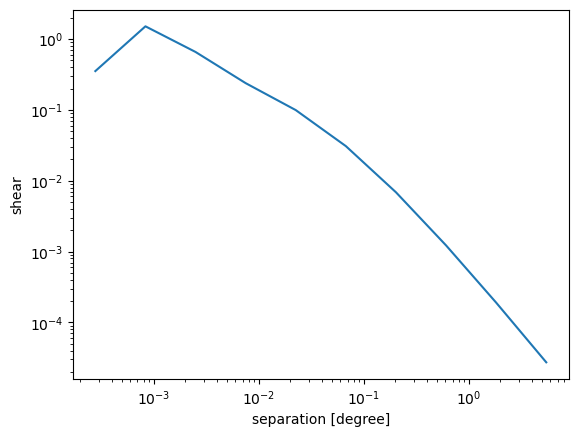

In [34]:
plt.plot(d_array / 3600., g_array)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("separation [degree]")
plt.ylabel("shear")